In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "150_1k_iso"
    npy_file_name_aniso = f"p_iso_150_1k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_iso_150_1k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The 150_1k_iso data size is: (76, 150, 150, 150)
READING DATA DONE
The 150_1k_iso energy data size is: (76, 150, 150, 150)
READING ENERGY DATA DONE


In [3]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 1000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix.item())
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    
                    # calculate or extract curvature
                    if pair_id not in curvature_matrix: continue
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

  0%|          | 0/51 [00:00<?, ?it/s]

Finish curvature calculation


  2%|▏         | 1/51 [00:48<40:46, 48.93s/it]

Current GBs len at 0 steps: 6949
Finish curvature calculation


  8%|▊         | 4/51 [03:10<37:09, 47.44s/it]

Current GBs len at 3 steps: 5426
Finish curvature calculation


 10%|▉         | 5/51 [03:57<36:05, 47.07s/it]

Current GBs len at 4 steps: 4676
Finish curvature calculation


 12%|█▏        | 6/51 [04:43<34:59, 46.67s/it]

Current GBs len at 5 steps: 4028
Finish curvature calculation


 14%|█▎        | 7/51 [05:28<33:55, 46.26s/it]

Current GBs len at 6 steps: 3549
Finish curvature calculation


 16%|█▌        | 8/51 [06:13<32:53, 45.90s/it]

Current GBs len at 7 steps: 3098
Finish curvature calculation


 18%|█▊        | 9/51 [06:58<31:56, 45.64s/it]

Current GBs len at 8 steps: 2733
Finish curvature calculation


 20%|█▉        | 10/51 [07:43<31:01, 45.40s/it]

Current GBs len at 9 steps: 2368
Finish curvature calculation


 22%|██▏       | 11/51 [08:28<30:01, 45.05s/it]

Current GBs len at 10 steps: 2005
Finish curvature calculation


 24%|██▎       | 12/51 [09:11<29:02, 44.69s/it]

Current GBs len at 11 steps: 1779
Finish curvature calculation


 25%|██▌       | 13/51 [09:55<28:05, 44.36s/it]

Current GBs len at 12 steps: 1619
Finish curvature calculation


 27%|██▋       | 14/51 [10:38<27:10, 44.06s/it]

Current GBs len at 13 steps: 1449
Finish curvature calculation


 29%|██▉       | 15/51 [11:21<26:15, 43.77s/it]

Current GBs len at 14 steps: 1255
Finish curvature calculation
Current GBs len at 15 steps: 1174


 31%|███▏      | 16/51 [12:05<25:25, 43.60s/it]

Finish curvature calculation


 33%|███▎      | 17/51 [12:48<24:36, 43.43s/it]

Current GBs len at 16 steps: 1046
Finish curvature calculation


 35%|███▌      | 18/51 [13:30<23:43, 43.15s/it]

Current GBs len at 17 steps: 959
Finish curvature calculation


 37%|███▋      | 19/51 [14:13<22:57, 43.05s/it]

Current GBs len at 18 steps: 908
Finish curvature calculation


 39%|███▉      | 20/51 [14:55<22:09, 42.88s/it]

Current GBs len at 19 steps: 838
Finish curvature calculation


 41%|████      | 21/51 [15:38<21:21, 42.72s/it]

Current GBs len at 20 steps: 790
Finish curvature calculation


 43%|████▎     | 22/51 [16:20<20:33, 42.53s/it]

Current GBs len at 21 steps: 756
Finish curvature calculation


 45%|████▌     | 23/51 [17:02<19:46, 42.39s/it]

Current GBs len at 22 steps: 710
Finish curvature calculation


 47%|████▋     | 24/51 [17:44<19:00, 42.22s/it]

Current GBs len at 23 steps: 666
Finish curvature calculation


 49%|████▉     | 25/51 [18:26<18:15, 42.14s/it]

Current GBs len at 24 steps: 615
Finish curvature calculation


 51%|█████     | 26/51 [19:07<17:30, 42.00s/it]

Current GBs len at 25 steps: 577
Finish curvature calculation


 53%|█████▎    | 27/51 [19:49<16:46, 41.93s/it]

Current GBs len at 26 steps: 507
Finish curvature calculation


 55%|█████▍    | 28/51 [20:31<16:02, 41.83s/it]

Current GBs len at 27 steps: 482
Finish curvature calculation


 57%|█████▋    | 29/51 [21:12<15:18, 41.77s/it]

Current GBs len at 28 steps: 468
Finish curvature calculation


 59%|█████▉    | 30/51 [21:54<14:35, 41.67s/it]

Current GBs len at 29 steps: 441
Finish curvature calculation


 61%|██████    | 31/51 [22:35<13:51, 41.58s/it]

Current GBs len at 30 steps: 417
Finish curvature calculation


 63%|██████▎   | 32/51 [23:16<13:08, 41.48s/it]

Current GBs len at 31 steps: 393
Finish curvature calculation


 65%|██████▍   | 33/51 [23:58<12:25, 41.41s/it]

Current GBs len at 32 steps: 370
Finish curvature calculation


 67%|██████▋   | 34/51 [24:39<11:42, 41.32s/it]

Current GBs len at 33 steps: 364
Finish curvature calculation


 69%|██████▊   | 35/51 [25:20<10:59, 41.23s/it]

Current GBs len at 34 steps: 358
Finish curvature calculation


 71%|███████   | 36/51 [26:01<10:18, 41.24s/it]

Current GBs len at 35 steps: 344
Finish curvature calculation


 73%|███████▎  | 37/51 [26:42<09:36, 41.17s/it]

Current GBs len at 36 steps: 333
Finish curvature calculation


 75%|███████▍  | 38/51 [27:23<08:53, 41.05s/it]

Current GBs len at 37 steps: 325
Finish curvature calculation


 76%|███████▋  | 39/51 [28:04<08:12, 41.00s/it]

Current GBs len at 38 steps: 313
Finish curvature calculation


 78%|███████▊  | 40/51 [28:45<07:30, 40.93s/it]

Current GBs len at 39 steps: 291
Finish curvature calculation


 80%|████████  | 41/51 [29:25<06:48, 40.85s/it]

Current GBs len at 40 steps: 279
Finish curvature calculation


 82%|████████▏ | 42/51 [30:06<06:06, 40.73s/it]

Current GBs len at 41 steps: 271
Finish curvature calculation


 84%|████████▍ | 43/51 [30:46<05:25, 40.64s/it]

Current GBs len at 42 steps: 265
Finish curvature calculation


 86%|████████▋ | 44/51 [31:27<04:44, 40.65s/it]

Current GBs len at 43 steps: 263
Finish curvature calculation


 88%|████████▊ | 45/51 [32:08<04:04, 40.75s/it]

Current GBs len at 44 steps: 256
Finish curvature calculation


 90%|█████████ | 46/51 [32:48<03:23, 40.69s/it]

Current GBs len at 45 steps: 228
Finish curvature calculation


 92%|█████████▏| 47/51 [33:29<02:42, 40.72s/it]

Current GBs len at 46 steps: 219
Finish curvature calculation


 94%|█████████▍| 48/51 [34:09<02:01, 40.55s/it]

Current GBs len at 47 steps: 199
Finish curvature calculation


 96%|█████████▌| 49/51 [34:50<01:20, 40.48s/it]

Current GBs len at 48 steps: 190
Finish curvature calculation


 98%|█████████▊| 50/51 [35:30<00:40, 40.33s/it]

Current GBs len at 49 steps: 177
Finish curvature calculation


100%|██████████| 51/51 [36:10<00:00, 42.55s/it]

Current GBs len at 50 steps: 169


In [4]:
    # GB Energy information
    step_num=51
    grain_nums = 1000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

  2%|▏         | 1/51 [00:33<28:03, 33.66s/it]

Current GBs len at 0 steps: 7440


  4%|▍         | 2/51 [01:05<26:34, 32.54s/it]

Current GBs len at 1 steps: 6986


  6%|▌         | 3/51 [01:36<25:24, 31.75s/it]

Current GBs len at 2 steps: 6241


  8%|▊         | 4/51 [02:06<24:16, 30.98s/it]

Current GBs len at 3 steps: 5520


 10%|▉         | 5/51 [02:35<23:12, 30.27s/it]

Current GBs len at 4 steps: 4743


 12%|█▏        | 6/51 [03:03<22:12, 29.61s/it]

Current GBs len at 5 steps: 4092


 14%|█▎        | 7/51 [03:30<21:11, 28.91s/it]

Current GBs len at 6 steps: 3606


 16%|█▌        | 8/51 [03:57<20:13, 28.21s/it]

Current GBs len at 7 steps: 3149


 18%|█▊        | 9/51 [04:23<19:17, 27.56s/it]

Current GBs len at 8 steps: 2779


 20%|█▉        | 10/51 [04:49<18:23, 26.92s/it]

Current GBs len at 9 steps: 2404


 22%|██▏       | 11/51 [05:13<17:31, 26.28s/it]

Current GBs len at 10 steps: 2036


 24%|██▎       | 12/51 [05:38<16:42, 25.70s/it]

Current GBs len at 11 steps: 1797


 25%|██▌       | 13/51 [06:02<15:55, 25.14s/it]

Current GBs len at 12 steps: 1635


 27%|██▋       | 14/51 [06:25<15:10, 24.61s/it]

Current GBs len at 13 steps: 1462


 29%|██▉       | 15/51 [06:48<14:27, 24.10s/it]

Current GBs len at 14 steps: 1273


 31%|███▏      | 16/51 [07:11<13:48, 23.67s/it]

Current GBs len at 15 steps: 1183


 33%|███▎      | 17/51 [07:33<13:11, 23.28s/it]

Current GBs len at 16 steps: 1058


 35%|███▌      | 18/51 [07:55<12:36, 22.92s/it]

Current GBs len at 17 steps: 970


 37%|███▋      | 19/51 [08:17<12:04, 22.63s/it]

Current GBs len at 18 steps: 916


 39%|███▉      | 20/51 [08:39<11:31, 22.31s/it]

Current GBs len at 19 steps: 845


 41%|████      | 21/51 [09:00<11:01, 22.04s/it]

Current GBs len at 20 steps: 794


 43%|████▎     | 22/51 [09:21<10:32, 21.82s/it]

Current GBs len at 21 steps: 759


 45%|████▌     | 23/51 [09:42<10:03, 21.56s/it]

Current GBs len at 22 steps: 712


 47%|████▋     | 24/51 [10:03<09:36, 21.34s/it]

Current GBs len at 23 steps: 670


 49%|████▉     | 25/51 [10:24<09:10, 21.16s/it]

Current GBs len at 24 steps: 623


 51%|█████     | 26/51 [10:44<08:42, 20.91s/it]

Current GBs len at 25 steps: 580


 53%|█████▎    | 27/51 [11:05<08:17, 20.73s/it]

Current GBs len at 26 steps: 510


 55%|█████▍    | 28/51 [11:25<07:52, 20.52s/it]

Current GBs len at 27 steps: 486


 57%|█████▋    | 29/51 [11:45<07:28, 20.37s/it]

Current GBs len at 28 steps: 470


 59%|█████▉    | 30/51 [12:05<07:05, 20.25s/it]

Current GBs len at 29 steps: 445


 61%|██████    | 31/51 [12:24<06:42, 20.12s/it]

Current GBs len at 30 steps: 417


 63%|██████▎   | 32/51 [12:44<06:20, 20.04s/it]

Current GBs len at 31 steps: 394


 65%|██████▍   | 33/51 [13:04<05:59, 19.96s/it]

Current GBs len at 32 steps: 371


 67%|██████▋   | 34/51 [13:23<05:36, 19.81s/it]

Current GBs len at 33 steps: 365


 69%|██████▊   | 35/51 [13:43<05:15, 19.70s/it]

Current GBs len at 34 steps: 359


 71%|███████   | 36/51 [14:02<04:53, 19.57s/it]

Current GBs len at 35 steps: 346


 73%|███████▎  | 37/51 [14:21<04:32, 19.46s/it]

Current GBs len at 36 steps: 333


 75%|███████▍  | 38/51 [14:41<04:12, 19.40s/it]

Current GBs len at 37 steps: 328


 76%|███████▋  | 39/51 [15:00<03:51, 19.29s/it]

Current GBs len at 38 steps: 313


 78%|███████▊  | 40/51 [15:19<03:31, 19.18s/it]

Current GBs len at 39 steps: 291


 80%|████████  | 41/51 [15:38<03:11, 19.13s/it]

Current GBs len at 40 steps: 279


 82%|████████▏ | 42/51 [15:56<02:51, 19.03s/it]

Current GBs len at 41 steps: 272


 84%|████████▍ | 43/51 [16:15<02:31, 18.95s/it]

Current GBs len at 42 steps: 266


 86%|████████▋ | 44/51 [16:34<02:11, 18.83s/it]

Current GBs len at 43 steps: 263


 88%|████████▊ | 45/51 [16:52<01:52, 18.74s/it]

Current GBs len at 44 steps: 256


 90%|█████████ | 46/51 [17:11<01:33, 18.64s/it]

Current GBs len at 45 steps: 230


 92%|█████████▏| 47/51 [17:29<01:14, 18.52s/it]

Current GBs len at 46 steps: 219


 94%|█████████▍| 48/51 [17:47<00:55, 18.41s/it]

Current GBs len at 47 steps: 199


 96%|█████████▌| 49/51 [18:05<00:36, 18.33s/it]

Current GBs len at 48 steps: 190


 98%|█████████▊| 50/51 [18:23<00:18, 18.25s/it]

Current GBs len at 49 steps: 177


100%|██████████| 51/51 [18:41<00:00, 22.00s/it]

Current GBs len at 50 steps: 171


In [5]:
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 6949/6949 [00:30<00:00, 229.98it/s]


finish 0 with num of GBs 2222, and collected num of GBs 835


100%|██████████| 6904/6904 [00:34<00:00, 197.96it/s]


finish 1 with num of GBs 2548, and collected num of GBs 2137


100%|██████████| 6151/6151 [00:33<00:00, 182.42it/s]


finish 2 with num of GBs 2473, and collected num of GBs 2847


100%|██████████| 5426/5426 [00:30<00:00, 176.20it/s]


finish 3 with num of GBs 2254, and collected num of GBs 3297


100%|██████████| 4676/4676 [00:27<00:00, 169.88it/s]


finish 4 with num of GBs 2030, and collected num of GBs 3604


100%|██████████| 4028/4028 [00:24<00:00, 161.67it/s]


finish 5 with num of GBs 1828, and collected num of GBs 3817


100%|██████████| 3549/3549 [00:22<00:00, 160.12it/s]


finish 6 with num of GBs 1627, and collected num of GBs 4004


 65%|██████▌   | 2022/3098 [00:13<00:08, 122.84it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
len(GB_id_focus_copy)

5106

In [7]:
    time_interval = 2
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 177/177 [00:00<00:00, 631822.82it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    # print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 3703
The ratio of anti-curvature GBs during whole simulations is 37.99507490252411% in 9746 GBs


In [9]:

    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)

    anti_c_num = 0
    for key in GB_id_focus:
        anti_c_num += GB_id_focus[key]
    print(f"The number of the GBs showing anti-curvature during whole simulations is {anti_c_num}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {anti_c_num/total_GB_num*100}% in {total_GB_num} GBs")
    # print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 18155
The ratio of anti-curvature GBs during whole simulations is 25.588442565186753% in 70950 GBs


<Figure size 432x288 with 0 Axes>

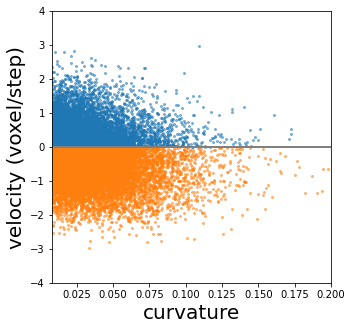

<Figure size 432x288 with 0 Axes>

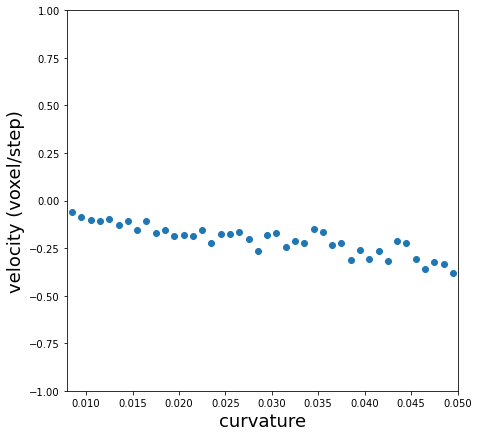

In [12]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
    velocity_1Dlist_exrandom_remove_0step = np.array(velocity_1Dlist_exrandom_remove_0step)
    curvature_1Dlist_exrandom_remove_0step = np.array(curvature_1Dlist_exrandom_remove_0step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.2],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.2])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.05])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


2.02414823014092


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

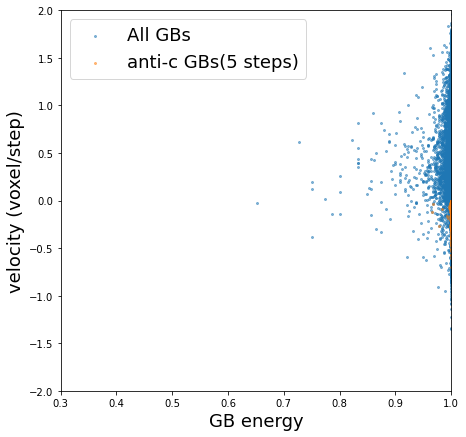

<Figure size 432x288 with 0 Axes>

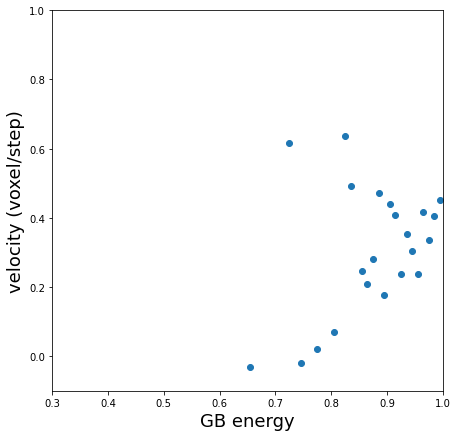

<Figure size 432x288 with 0 Axes>

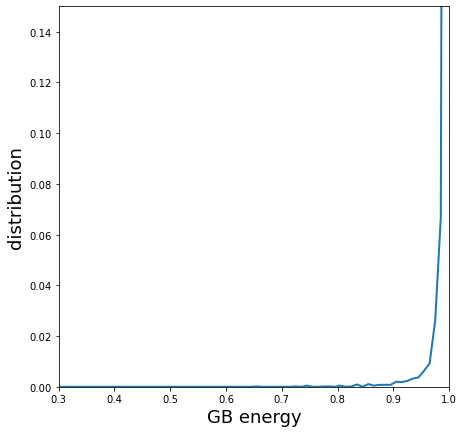

<Figure size 432x288 with 0 Axes>

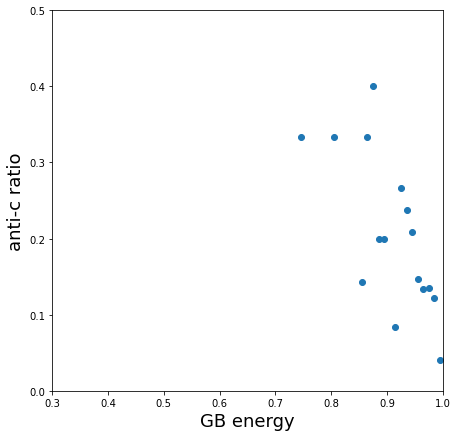

<Figure size 432x288 with 0 Axes>

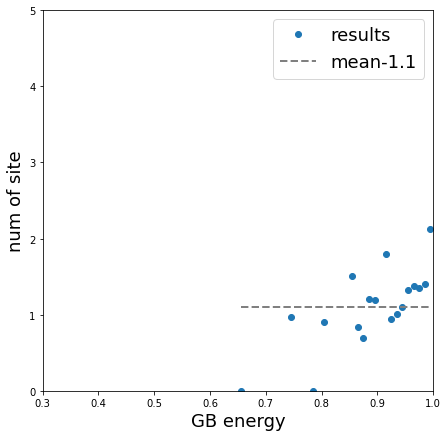

In [13]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-2,2])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/3D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        x_lim = [0.0,0.1]
        bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
        curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>x_lim[1]: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/3D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')